In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_extraction import DictVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer
from sklearn.metrics import brier_score_loss

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import json

import Feature_Extraction as fe

In [2]:
# load the dataset

data = open('data/tousend_cons_rels.CSV', encoding="ANSI").read()
label, r1, r2, rmix = [], [], [], []
size = 500
for i, line in enumerate(data.split("\n")):
    if i >= size:
        break
    if line != '' and line.isspace() != True:
        content = line.split(';')
        label.append(content[0])
        r1.append(content[1])
        r2.append(content[2])
        rmix.append(content[1]+content[2])
        
index = 0
size = len(label)
x = []
while index < size:
    x.append(fe.createFBag(r1[index], r2[index]))
    index = index + 1
    
vec = DictVectorizer()

xx = vec.fit_transform(x).toarray()

yy = []
for l in label:
    if l == 'true':
        yy.append(1)
    else:
        yy.append(-1)

In [75]:
yy2 = []
for val in yy:
    if val == 1:
        yy2.append(1)
    else:
        yy2.append(0)

In [ ]:
#0.65 (+/-0.40) for {'C': 0.23357214690901212, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}
LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
#ComplementNM is an implementation of MultinomialNB
NB_clf = ComplementNB()
#min_samples_leaf = 1 --> the most important parameter, min_samples_split = 2 or 5 --> second most important
#0.64 (+/-0.39) for {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)


In [98]:
import warnings
warnings.filterwarnings('ignore')


kfold = 5
cv = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=10)

#train_sizes = [50, 100, 150, 200, 250, 300, 350, 400,  450, 500]
train_sizes = range(10, 500, 10)

#scoring =  {'brier_score_loss': make_scorer(brier_score_loss, pos_label=1)}
scoring =  {'brier_score_loss': make_scorer(brier_score_loss, pos_label=1)}
score_keys = ['test_brier_score_loss', 'train_brier_score_loss']
LR_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}
NB_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}
ET_scores =  {'test_brier_score_loss':[], 'train_brier_score_loss':[]}

for size in train_sizes:
    
    LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
    NB_clf = ComplementNB()
    ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)
    clfs = [LR_clf, NB_clf, ET_clf]
    
    for clf in clfs:
        res = cross_validate(clf, X=xx[:size], y=yy2[:size], cv=cv, scoring=scoring, return_train_score=True)
        
        for key in score_keys:
            if clf == LR_clf:
                LR_scores[key].append(np.absolute(np.mean(res[key])))
            elif clf == NB_clf:
                NB_scores[key].append(np.absolute(np.mean(res[key])))
            else:
                ET_scores[key].append(np.absolute(np.mean(res[key])))
                    

In [99]:
LR_df = pd.DataFrame(LR_scores)
NB_df = pd.DataFrame(NB_scores)
ET_df = pd.DataFrame(ET_scores)

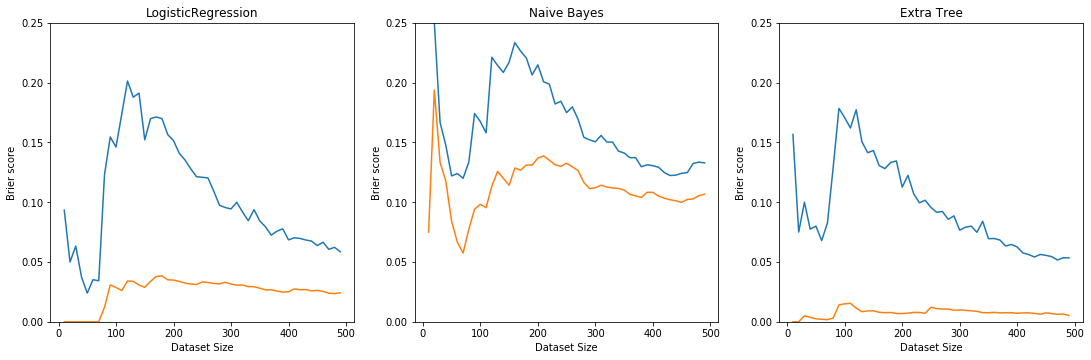

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

lrp = sns.lineplot(train_sizes, LR_df['test_brier_score_loss'], ax=ax1)
lrp = sns.lineplot(train_sizes, LR_df['train_brier_score_loss'], ax=ax1)
lrp.set(xlabel='Dataset Size', ylabel='Brier score')
lrp.set_title('LogisticRegression')
lrp.set_ylim(ymin=0, ymax=0.25)

nbp = sns.lineplot(train_sizes, NB_df['test_brier_score_loss'], ax=ax2)
nbp = sns.lineplot(train_sizes, NB_df['train_brier_score_loss'], ax=ax2)
nbp.set(xlabel='Dataset Size', ylabel='Brier score')
nbp.set_title('Naive Bayes')
nbp.set_ylim(ymin=0, ymax=0.25)

etp = sns.lineplot(train_sizes, ET_df['test_brier_score_loss'], ax=ax3)
etp = sns.lineplot(train_sizes, ET_df['train_brier_score_loss'], ax=ax3)
etp.set(xlabel='Dataset Size', ylabel='Brier score')
etp.set_title('Extra Tree')
etp.set_ylim(ymin=0, ymax=0.25)

plt.savefig('learning_cureves.pdf', bbox_inches = "tight")

In [102]:
#best found threshold = 0.3
def classifyOnSimilarity(s1, s2, threshold):
    ns = fe.getNounSimilarityPortion(s1, s2)
    if ns == 'low':
        ns = 0
    vs = fe.getVerbSimilarityPortion(s1, s2)
    if vs == 'low':
        vs = 0
    sim = (ns + vs) / 2
    myy = -1
    if sim > threshold:
        myy = 1
    return myy

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
def calculateCosine(s1, s2):
    sw = stopwords.words('english')  
    s1_list = word_tokenize(s1)  
    s2_list = word_tokenize(s2)
    # remove stop words from string 
    s1_set = {w for w in s1_list if not w in sw}  
    s2_set = {w for w in s2_list if not w in sw}
    l1 =[]
    l2 =[] 
    # form a set containing keywords of both strings  
    rvector = s1_set.union(s2_set)  
    for w in rvector: 
        if w in s1_set:
            l1.append(1)
        else:
            l1.append(0) 
        if w in s2_set:
            l2.append(1) 
        else:
            l2.append(0)
    c = 0
    # cosine formula
    for i in range(len(rvector)): 
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine

#best found threshold = 0.4
def classifyCosine(s1, s2, threshold):
    cos = calculateCosine(s1, s2)
    if cos > threshold:
        return 1
    else:
        return -1

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga75xoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
predicted = []
for i in range(len(yy)):
    predicted.append(classifyCosine(r1[i], r2[i], 0.4))
print(classification_report(yy, predicted))

              precision    recall  f1-score   support

          -1       0.92      0.76      0.84       449
           1       0.18      0.45      0.25        51

    accuracy                           0.73       500
   macro avg       0.55      0.61      0.54       500
weighted avg       0.85      0.73      0.78       500



In [104]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [106]:
data = {'precision': {}, 'recall' : {}, 'f1' : {},
            'tp' : {}, 'fp' : {}, 'tn' : {}, 'fn' : {}}

In [107]:
kfold = 5
rskf = RepeatedStratifiedKFold(n_splits=kfold, n_repeats=10, random_state=11)

LR_clf =  LogisticRegression(C=4.281332398719396, class_weight='balanced', penalty= 'l1', solver= 'liblinear')
NB_clf = ComplementNB()
ET_clf = ExtraTreesClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10)
clfs = [LR_clf, NB_clf, ET_clf]

for clf in clfs:
    scoring =  {'precision':'precision', 'recall':'recall', 'f1':'f1', 'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}
    res = cross_validate(clf, X=xx, y=yy, cv=rskf, scoring=scoring, n_jobs=-1)
    for scr in scoring.keys():
                data[scr][type(clf).__name__] = res['test_' + scr].tolist()

In [109]:
precision_df = pd.DataFrame(data['precision'])
recall_df = pd.DataFrame(data['recall'])
f1_df = pd.DataFrame(data['f1'])

In [127]:
df = pd.DataFrame(columns=['LogisticRegression', 'MultinomialNB', 'ExtraTrees', 'CosineSimilarity'],
                  index=['Precision', 'PrecisionVariance', 'Recall', 'RecallVariance', 'f1', 'f1Variance'])
df['LogisticRegression'] = [np.mean(precision_df['LogisticRegression']), np.var(precision_df['LogisticRegression']),
                            np.mean(recall_df['LogisticRegression']), np.var(recall_df['LogisticRegression']),
                            np.mean(f1_df['LogisticRegression']), np.var(f1_df['LogisticRegression'])]

df['MultinomialNB'] = [np.mean(precision_df['ComplementNB']), np.var(precision_df['ComplementNB']),
                            np.mean(recall_df['ComplementNB']), np.var(recall_df['ComplementNB']),
                            np.mean(f1_df['ComplementNB']), np.var(f1_df['ComplementNB'])]

df['ExtraTrees'] = [np.mean(precision_df['ExtraTreesClassifier']), np.var(precision_df['ExtraTreesClassifier']),
                            np.mean(recall_df['ExtraTreesClassifier']), np.var(recall_df['ExtraTreesClassifier']),
                            np.mean(f1_df['ExtraTreesClassifier']), np.var(f1_df['ExtraTreesClassifier'])]

df['CosineSimilarity'] = [0.18, '-', 0.45, '-', 0.25, '-']

df

,LogisticRegression,MultinomialNB,ExtraTrees,CosineSimilarity
Precision,0.676236,0.430902,0.879172,0.18
PrecisionVariance,0.005939,0.002800,0.015562,-
Recall,0.827818,0.856364,0.620545,0.45
RecallVariance,0.010844,0.009101,0.018327,-
f1,0.739074,0.571261,0.716509,0.25
f1Variance,0.003939,0.003437,0.011942,-


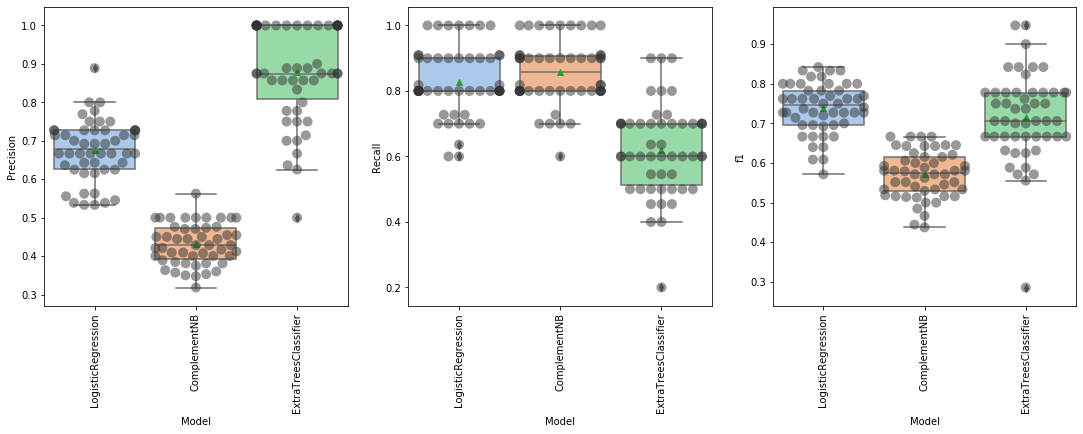

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 5.5)

axp = sns.boxplot(data=precision_df, showmeans=True, palette="pastel", ax=ax1)
axp = sns.swarmplot(data=precision_df, size=10, orient="v", color='.2', alpha=0.5, ax=ax1)
axp.set(xlabel='Model', ylabel='Precision')
axp.set_xticklabels(axp.get_xticklabels(),rotation=90)

axr = sns.boxplot(data=recall_df, showmeans=True, palette="pastel", ax=ax2)
axp = sns.swarmplot(data=recall_df, size=10, orient="v", color='.2', alpha=0.5, ax=ax2)
axr.set(xlabel='Model', ylabel='Recall')
axr.set_xticklabels(axp.get_xticklabels(),rotation=90)

axr = sns.boxplot(data=f1_df, showmeans=True, palette="pastel", ax=ax3)
axp = sns.swarmplot(data=f1_df, size=10, orient="v", color='.2', alpha=0.5, ax=ax3)
axr.set(xlabel='Model', ylabel='f1')
axr.set_xticklabels(axp.get_xticklabels(),rotation=90)

plt.savefig('modelcomparison_1.pdf', bbox_inches = "tight")